In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
sys.path.append('../')
sys.path.append("../../../tejaas/")
from iotools.readRPKM import ReadRPKM
import pandas as pd
import numpy as np
import pandas as pd
import gzip
from utils import utils
# from gtex_normalization import normalize_expression

def centerscale_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_donors(path):
    donor_ids = list()
    with open(path, 'r') as instream:
        # skip first two lines
        next(instream)
        next(instream)
        for line in instream:
            donor_ids.append(line.strip().split()[0])
    return donor_ids

def read_gct(gct_file, donor_ids):
    """
    Load GCT as DataFrame
    """    
    df = pd.read_csv(gct_file, sep='\t', skiprows=2, index_col=0)
    df.drop('Description', axis=1, inplace=True)
    df.index.name = 'gene_id'
    df = df[[i for i in df.columns if '-'.join(i.split('-')[:2]) in donor_ids]]
    return df

import scipy.stats as stats

def normalize_quantiles(df):
    """
    Quantile normalization to the average empirical distribution
    Note: replicates behavior of R function normalize.quantiles from library("preprocessCore")
    Reference:
     [1] Bolstad et al., Bioinformatics 19(2), pp. 185-193, 2003
    Adapted from https://github.com/andrewdyates/quantile_normalize
    """
    M = df.values.copy()

    Q = M.argsort(axis=0)
    m,n = M.shape

    # compute quantile vector
    quantiles = np.zeros(m)
    for i in range(n):
        quantiles += M[Q[:,i],i]
    quantiles = quantiles / n

    for i in range(n):
        # Get equivalence classes; unique values == 0
        dupes = np.zeros(m, dtype=np.int)
        for j in range(m-1):
            if M[Q[j,i],i]==M[Q[j+1,i],i]:
                dupes[j+1] = dupes[j]+1

        # Replace column with quantile ranks
        M[Q[:,i],i] = quantiles

        # Average together equivalence classes
        j = m-1
        while j >= 0:
            if dupes[j] == 0:
                j -= 1
            else:
                idxs = Q[j-dupes[j]:j+1,i]
                M[idxs,i] = np.median(M[idxs,i])
                j -= 1 + dupes[j]
        assert j == -1

    return pd.DataFrame(M, index=df.index, columns=df.columns)
      
def inverse_normal_transform(M):
    """
    Transform rows to a standard normal distribution
    """
    R = stats.mstats.rankdata(M, axis=1)  # ties are averaged
    if isinstance(M, pd.DataFrame):
        Q = pd.DataFrame(stats.norm.ppf(R/(M.shape[1]+1)), index=M.index, columns=M.columns)
    else:
        Q = stats.norm.ppf(R/(M.shape[1]+1))
    return Q

# def normalize_expression(expression_df, counts_df, expression_threshold=0.1, count_threshold=5, min_samples=10):
#     """
#     Genes are thresholded based on the following expression rules:
#       >=min_samples with >expression_threshold expression values
#       >=min_samples with >count_threshold read counts
#     """
#     # donor_ids = ['-'.join(i.split('-')[:2]) for i in expression_df.columns]
#     donor_ids = expression_df.columns
    
#     # expression thresholds
#     mask = ((np.sum(expression_df>expression_threshold,axis=1)>=min_samples) & (np.sum(counts_df>count_threshold,axis=1)>=min_samples)).values
    
#     # apply normalization
#     M = normalize_quantiles(expression_df.loc[mask])
#     R = inverse_normal_transform(M)

#     quant_std_df = pd.DataFrame(data=R, columns=donor_ids, index=expression_df.loc[mask].index)    
#     quant_df = pd.DataFrame(data=M, columns=donor_ids, index=expression_df.loc[mask].index)
#     return quant_std_df, quant_df


### Apply LM correction (python)
from sklearn import linear_model

def lmcorrect(expression_df, cov_df):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.LinearRegression()
    reg.fit(cov_df.T, expression_df.T)

    # reg.score(df_cov.T, crop_expression_df.T)
    # print(reg.coef_)
    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_


In [4]:
import warnings

def QC_expression(counts_df, expr_df, sample_frac_threshold=0.2, count_threshold=6, expr_threshold=0.1, mode='tmm'):
    ns = expr_df.shape[1]

    # expression thresholds
    if mode.lower()=='tmm':
        mask = (
            (np.sum(expr_df>=expr_threshold,axis=1)>=sample_frac_threshold*ns) &
            (np.sum(counts_df>=count_threshold,axis=1)>=sample_frac_threshold*ns)
        ).values
    else:
        mask = (
            (np.sum(expr_df>=expr_threshold,axis=1)>=10) &
            (np.sum(counts_df>=count_threshold,axis=1)>=10)
        ).values
    
    return expr_df.loc[mask], counts_df.loc[mask]    

def prepare_expression(counts_df, tpm_df, sample_frac_threshold=0.2, count_threshold=6, expr_threshold=0.1, mode='tmm'):
    """
    Genes are thresholded based on the following expression rules:
      TPM >= tpm_threshold in >= sample_frac_threshold*samples
      read counts >= count_threshold in sample_frac_threshold*samples
       
    Between-sample normalization modes:
      tmm: TMM from edgeR
      qn:  quantile normalization
    """

    ns = tpm_df.shape[1]

    # expression thresholds
    if mode.lower()=='tmm':
        mask = (
            (np.sum(tpm_df>=tpm_threshold,axis=1)>=sample_frac_threshold*ns) &
            (np.sum(counts_df>=count_threshold,axis=1)>=sample_frac_threshold*ns)
        ).values
    else:
        mask = (
            (np.sum(tpm_df>=tpm_threshold,axis=1)>=10) &
            (np.sum(counts_df>=count_threshold,axis=1)>=10)
        ).values

    # apply normalization
    if mode.lower()=='tmm':
        tmm_counts_df = edgeR_cpm(counts_df, normalized_lib_sizes=True)
        norm_df = inverse_normal_transform(tmm_counts_df[mask])
    elif mode.lower()=='qn':
        qn_df = normalize_quantiles(tpm_df.loc[mask])
        norm_df = inverse_normal_transform(qn_df)       
    else:
        raise ValueError('Unsupported mode {}'.format(mode))

    tmm_norm_df = pd.DataFrame(norm_df, columns=expression_df.columns, index=expression_df.index[mask])
    tmm_norm_df.index.name = "gene_id"
    
    return tmm_norm_df

def edgeR_calcNormFactors(counts_df, ref=None, logratio_trim=0.3, sum_trim=0.05, acutoff=-1e10, verbose=False):
    """
    Calculate TMM (Trimmed Mean of M values) normalization.
    Reproduces edgeR::calcNormFactors.default
    Scaling factors for the library sizes that minimize the log-fold changes between the samples for most genes.
    Effective library size: TMM scaling factor * library size
    References:
     [1] Robinson & Oshlack, 2010
     [2] R functions:
          edgeR::calcNormFactors.default
          edgeR:::.calcFactorWeighted
          edgeR:::.calcFactorQuantile
    """

    # discard genes with all-zero counts
    Y = counts_df.values.copy()
    allzero = np.sum(Y>0,axis=1)==0
    if np.any(allzero):
        Y = Y[~allzero,:]

    # select reference sample
    if ref is None:  # reference sample index
        f75 = np.percentile(Y/np.sum(Y,axis=0), 75, axis=0)
        ref = np.argmin(np.abs(f75-np.mean(f75)))
        if verbose:
            print('Reference sample index: '+str(ref))

    N = np.sum(Y, axis=0)  # total reads in each library

    # with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        logR = np.log2((Y/N).T / (Y[:,ref]/N[ref])).T  # log fold change; Mg in [1]
        absE = 0.5*(np.log2(Y/N).T + np.log2(Y[:,ref]/N[ref])).T  # average log relative expression; Ag in [1]
        v = (N-Y)/N/Y
        v = (v.T + v[:,ref]).T  # w in [1]

    ns = Y.shape[1]
    tmm = np.zeros(ns)
    for i in range(ns):
        fin = np.isfinite(logR[:,i]) & np.isfinite(absE[:,i]) & (absE[:,i] > acutoff)
        n = np.sum(fin)

        loL = np.floor(n*logratio_trim)+1
        hiL = n + 1 - loL
        loS = np.floor(n*sum_trim)+1
        hiS = n + 1 - loS
        rankR = stats.rankdata(logR[fin,i])
        rankE = stats.rankdata(absE[fin,i])
        keep = (rankR >= loL) & (rankR <= hiL) & (rankE >= loS) & (rankE <= hiS)
        # in [1], w erroneously defined as 1/v ?
        tmm[i] = 2**(np.nansum(logR[fin,i][keep]/v[fin,i][keep]) / np.nansum(1/v[fin,i][keep]))

    tmm = tmm / np.exp(np.mean(np.log(tmm)))
    return tmm


def edgeR_cpm(counts_df, tmm=None, normalized_lib_sizes=True):
    """
    Return edgeR normalized/rescaled CPM (counts per million)
    Reproduces edgeR::cpm.DGEList
    """
    lib_size = counts_df.sum(axis=0)
    if normalized_lib_sizes:
        if tmm is None:
            tmm = edgeR_calcNormFactors(counts_df)
        lib_size = lib_size * tmm
    return counts_df / lib_size * 1e6

def correct_lasso_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    if not isinstance(expression_df, pd.DataFrame):
        print("Expression matrix must be a DataFrame")
        raise
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Lasso(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    df_residuals.index.name = expression_df.index.name
    return df_residuals, coefs

In [26]:
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
tissuenames = ["ms"]
# tissues = ["gtex-"+t for t in tissuenames]

processpath="/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/"

# tissue="ms"
for tissue in tissuenames:
    print(tissue)
    rpkmpath=processpath+"rpkms/{:s}_rpkm.gct".format(tissue)
    countspath=processpath+"rpkms/{:s}_counts.gct".format(tissue)
    donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

    expression_threshold=0.1    # 'Selects genes with > expression_threshold expression in at least min_samples')
    count_threshold=5,          # 'Selects genes with > count_threshold reads in at least min_samples')
    min_samples=10              # 'Minimum number of samples that must satisfy thresholds')

    donor_ids = get_donors(donorspath)
    expression_df = read_gct(rpkmpath, donor_ids)
    counts_df = read_gct(countspath, donor_ids)

    if expression_df.shape[1] < min_samples:
        raise ValueError("tissue has less samples than threshold")

    # match sample ids
    expr_ids = list(expression_df.columns)
    tissue_counts_df = counts_df.loc[:,expr_ids]
    
    newcolumns = ["-".join(i.split("-")[:2]) for i in expr_ids]
    expression_df.columns = newcolumns
    tissue_counts_df.columns = newcolumns
    
    convert_tpm = True
    if convert_tpm:
        print('  * Converting to TPM')
        tpm_expr_df = expression_df/expression_df.sum(0)*1e6
        
    # load covariates
    covfile = processpath+"covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov = pd.read_table(covfile, header=0, index_col=0)

    # scale covariates
    means = np.mean(df_cov.T)
    stds = np.std(df_cov.T)
    diff = (df_cov.T - means) / stds
    scaled_df_cov = diff.T
    
    # QC filtering
    if convert_tpm:
        qc_expr, qc_counts = QC_expression(tissue_counts_df, tpm_expr_df, \
                                           count_threshold=count_threshold, \
                                           expr_threshold=expression_threshold, mode="qn") # qn mode is just to bypass strict filtering
        qc_expr.to_csv(processpath+"rpkms/{:s}_tpms_qcfilter.txt".format(tissue), sep="\t")
        qc_counts.to_csv(processpath+"rpkms/{:s}_counts_qcfilter.txt".format(tissue), sep="\t")
    else:
        qc_expr, qc_counts = QC_expression(tissue_counts_df, expression_df, \
                                           count_threshold=count_threshold, \
                                           expr_threshold=expression_threshold, mode="qn") # qn mode is just to bypass strict filtering
        qc_expr.to_csv(processpath+"rpkms/{:s}_rpkms_qcfilter.txt".format(tissue), sep="\t")
        qc_counts.to_csv(processpath+"rpkms/{:s}_counts_qcfilter.txt".format(tissue), sep="\t")
    
    # TMM transformation
    print("Applying TMM transformation")
    tmm_counts_df = edgeR_cpm(qc_counts, normalized_lib_sizes=True)
    norm_df = inverse_normal_transform(tmm_counts_df)
    
    # QN transformation
    print("Applying QN transformation")
    qn_df = normalize_quantiles(qc_expr)
    norm_df_qn = inverse_normal_transform(qn_df)
    
#     qn_lasso_expr, lasso_coefs = correct_lasso_iterative(centerscale_expr(qn_df), scaled_df_cov)
#     tmm_lasso_expr, lasso_coefs = correct_lasso_iterative(centerscale_expr(tmm_counts_df), scaled_df_cov)
    
#     # center and scale lasso expression
#     print("Center and Scaling of lasso results")
#     tmm_lasso_it = centerscale_expr(tmm_lasso_expr)
#     qn_lasso_it  = centerscale_expr(qn_lasso_expr)
    
#     print("Writing expression files")
#     if not os.path.exists(processpath+"tmm_lasso"):
#          os.makedirs(processpath+"tmm_lasso")
#     tmm_lasso_it.to_csv(processpath+"tmm_lasso/{:s}_tmm_lasso.txt".format(tissue), sep="\t")
    
#     if not os.path.exists(processpath+"qn_lasso"):
#          os.makedirs(processpath+"qn_lasso")
#     tmm_lasso_it.to_csv(processpath+"qn_lasso/{:s}_qn_lasso.txt".format(tissue), sep="\t")
    
#     if not os.path.exists(processpath+"qn"):
#          os.makedirs(processpath+"qn")
#     centerscale_expr(qn_df).to_csv(processpath+"qn/{:s}_qn.txt".format(tissue), sep="\t")
    
#     if not os.path.exists(processpath+"tmm"):
#          os.makedirs(processpath+"tmm")
#     centerscale_expr(tmm_counts_df).to_csv(processpath+"tmm/{:s}_tmm.txt".format(tissue), sep="\t")

ms
  * Converting to TPM
Applying TMM transformation
Applying QN transformation


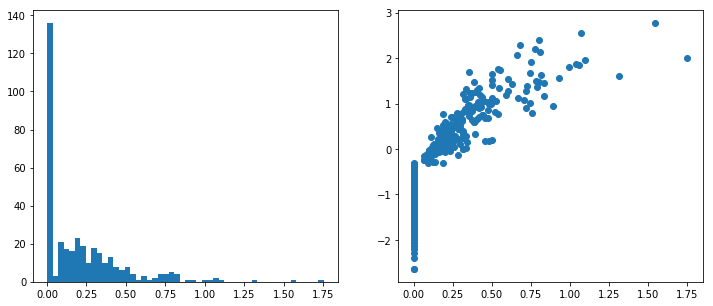

In [28]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ix = 0
gid="ENSG00000239906.1"
ax1.hist(qc_expr.loc[gid], bins=50)
# ax2.hist(norm_df_qn.loc[gid], bins=50)
ax2.scatter(qc_expr.loc[gid], norm_df_qn.loc[gid])
plt.show()

In [10]:
print(np.linalg.matrix_rank(qc_expr))
print(np.linalg.matrix_rank(qn_df))
print(np.linalg.matrix_rank(norm_df_qn))
print(np.linalg.matrix_rank(tmm_counts_df))

361
361
361
361


(25272, 361)


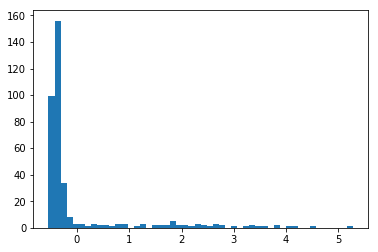

In [23]:
import matplotlib.pyplot as plt
print(qn_df.shape)

plt.hist(centerscale_expr(tmm_counts_df).iloc[10], bins=50)
plt.show()

# plt.hist(norm_df_qn.iloc[4], bins=50)
# plt.show()

# plt.scatter(qn_df[0,:], qc_counts.values[0,:])
# plt.show()

# plt.scatter(norm_df_qn[0,:], qc_counts.values[0,:])
# plt.show()

# plt.scatter(norm_df_qn.iloc[4], qn_df.iloc[4])
plt.show()

In [20]:
centerscale_expr(tmm_counts_df.loc[:,["GTEX-P4PP","GTEX-SNOS","GTEX-PW2O","GTEX-RU72","GTEX-U3ZH","GTEX-PLZ4","GTEX-WOFL","GTEX-R55D","GTEX-Q2AG","GTEX-QDT8","GTEX-QV31","GTEX-PLZ6","GTEX-TMMY","GTEX-OIZG","GTEX-WYJK","GTEX-XBED","GTEX-U8XE","GTEX-X5EB","GTEX-QEG4","GTEX-VUSG","GTEX-U8T8","GTEX-QLQ7","GTEX-S4UY","GTEX-SJXC","GTEX-SIU7","GTEX-WL46","GTEX-QLQW","GTEX-REY6","GTEX-V955","GTEX-S4Z8","GTEX-S32W","GTEX-OOBJ","GTEX-Q734","GTEX-WHPG","GTEX-X8HC","GTEX-W5WG","GTEX-WFG8","GTEX-OXRN","GTEX-QEG5","GTEX-U412","GTEX-WFON","GTEX-S7SF","GTEX-WXYG","GTEX-OOBK","GTEX-S341","GTEX-WEY5","GTEX-R55E","GTEX-T5JW","GTEX-S4P3","GTEX-Q2AH","GTEX-WRHK","GTEX-X4EO","GTEX-TML8","GTEX-TMZS","GTEX-QDVJ","GTEX-T6MN","GTEX-SN8G","GTEX-R3RS","GTEX-WY7C","GTEX-QEL4","GTEX-SNMC","GTEX-T2IS","GTEX-U3ZN","GTEX-S7PM","GTEX-V1D1","GTEX-R55F","GTEX-O5YT","GTEX-UJMC","GTEX-POMQ","GTEX-NPJ8","GTEX-RU1J","GTEX-OHPM","GTEX-U4B1","GTEX-VJWN","GTEX-WHSE","GTEX-SUCS","GTEX-R55C","GTEX-RN64","GTEX-P44H","GTEX-UPJH","GTEX-S33H","GTEX-P78B","GTEX-OIZI","GTEX-X261","GTEX-WK11","GTEX-U3ZM","GTEX-N7MS","GTEX-X4XX","GTEX-RTLS","GTEX-WZTO","GTEX-PWOO","GTEX-RNOR","GTEX-XAJ8","GTEX-P4QR","GTEX-T5JC","GTEX-TKQ1","GTEX-SSA3","GTEX-WHSB","GTEX-TSE9","GTEX-WOFM","GTEX-WYVS","GTEX-PWN1","GTEX-OXRL","GTEX-WRHU","GTEX-QDVN","GTEX-X4XY","GTEX-SIU8","GTEX-PSDG","GTEX-R53T","GTEX-POYW","GTEX-QESD","GTEX-OHPK","GTEX-PLZ5","GTEX-WFG7","GTEX-RWS6","GTEX-R55G","GTEX-P4PQ","GTEX-QCQG","GTEX-OXRK","GTEX-OHPN","GTEX-P4QT","GTEX-S3XE","GTEX-PX3G","GTEX-T8EM","GTEX-TKQ2","GTEX-S4Q7","GTEX-RM2N","GTEX-S95S","GTEX-UTHO","GTEX-WWYW","GTEX-OIZH","GTEX-QV44","GTEX-RWSA","GTEX-P4QS","GTEX-PWCY","GTEX-RVPU","GTEX-O5YV","GTEX-UJHI","GTEX-NFK9","GTEX-QXCU","GTEX-OHPL","GTEX-OXRP","GTEX-QVJO","GTEX-Y114","GTEX-ZTPG","GTEX-1211K","GTEX-1399R","GTEX-139TT","GTEX-11LCK","GTEX-ZVT4","GTEX-Y5V5","GTEX-11NUK","GTEX-U3ZG","GTEX-13O1R","GTEX-12WSG","GTEX-ZVZO","GTEX-13OVI","GTEX-12ZZY","GTEX-XYKS","GTEX-ZF3C","GTEX-11ZTS","GTEX-11UD2","GTEX-13111","GTEX-ZPIC","GTEX-13OW5","GTEX-13SLX","GTEX-ZE7O","GTEX-ZQUD","GTEX-13NYC","GTEX-ZAB5","GTEX-11GSO","GTEX-13N1W","GTEX-ZAB4","GTEX-ZVE1","GTEX-11GSP","GTEX-ZF2S","GTEX-111CU","GTEX-11ZU8","GTEX-11DXX","GTEX-12WSH","GTEX-13W3W","GTEX-XQ3S","GTEX-YBZK","GTEX-12584","GTEX-13112","GTEX-ZZ64","GTEX-ZVZP","GTEX-13CF2","GTEX-11DXZ","GTEX-1128S","GTEX-11GS4","GTEX-1122O","GTEX-11P81","GTEX-139YR","GTEX-139T6","GTEX-13OW7","GTEX-12ZZX","GTEX-13NZ8","GTEX-13OVG","GTEX-11EM3","GTEX-XUZC","GTEX-13PL6","GTEX-YFCO","GTEX-XQ8I","GTEX-13O3O","GTEX-13FTW","GTEX-11DXY","GTEX-13U4I","GTEX-ZDYS","GTEX-ZXG5","GTEX-13S7M","GTEX-Y5LM","GTEX-1399U","GTEX-13FTX","GTEX-ZYFC","GTEX-13FHP","GTEX-139TU","GTEX-Z9EW","GTEX-1399Q","GTEX-111YS","GTEX-13D11","GTEX-13RTK","GTEX-13OW8","GTEX-13FTY","GTEX-11P82","GTEX-13JVG","GTEX-12ZZZ","GTEX-YECK","GTEX-XOT4","GTEX-11ZUS","GTEX-XUYS","GTEX-1339X","GTEX-133LE","GTEX-ZVT3","GTEX-139UW","GTEX-111VG","GTEX-13N2G","GTEX-XBEW","GTEX-ZZPU","GTEX-13NZB","GTEX-ZT9X","GTEX-13NZA","GTEX-XV7Q","GTEX-ZYWO","GTEX-11TUW","GTEX-11ZTT","GTEX-13G51","GTEX-13O3P","GTEX-XPT6","GTEX-145MO","GTEX-Y111","GTEX-Y5V6","GTEX-12WSC","GTEX-13FXS","GTEX-11XUK","GTEX-13N11","GTEX-11UD1","GTEX-ZAJG","GTEX-X638","GTEX-YB5K","GTEX-12WSJ","GTEX-13PL7","GTEX-11EQ9","GTEX-XMD2","GTEX-1192X","GTEX-ZQG8","GTEX-13NYB","GTEX-13VXT","GTEX-12KS4","GTEX-13X6K","GTEX-13JUV","GTEX-1117F","GTEX-13VXU","GTEX-12WSD","GTEX-13FTZ","GTEX-YFC4","GTEX-11ZVC","GTEX-ZYFD","GTEX-ZYT6","GTEX-11WQK","GTEX-ZY6K","GTEX-XUJ4","GTEX-XPVG","GTEX-ZLV1","GTEX-Z93S","GTEX-Y8E4","GTEX-13QIC","GTEX-ZV6S","GTEX-ZUA1","GTEX-13QBU","GTEX-YB5E","GTEX-ZVP2","GTEX-12WSN","GTEX-ZV7C","GTEX-ZVT2","GTEX-ZPCL","GTEX-13OVJ","GTEX-139TS","GTEX-13IVO","GTEX-111FC","GTEX-12WSA","GTEX-13PLJ","GTEX-12WSL","GTEX-11NV4","GTEX-Y3I4","GTEX-113JC","GTEX-11I78","GTEX-XUW1","GTEX-13CF3","GTEX-1399T","GTEX-11EMC","GTEX-Y8E5","GTEX-13OVH","GTEX-11WQC","GTEX-Y8LW","GTEX-X88G","GTEX-13QJ3","GTEX-11EI6","GTEX-117YW","GTEX-12696","GTEX-11P7K","GTEX-11DXW","GTEX-11PRG","GTEX-ZA64","GTEX-13OW6","GTEX-13S86","GTEX-ZYY3","GTEX-13O3Q","GTEX-Y9LG","GTEX-13NYS","GTEX-ZV68","GTEX-13SLW","GTEX-ZC5H","GTEX-13O21","GTEX-12WSM","GTEX-11VI4","GTEX-11DZ1","GTEX-YEC4","GTEX-ZYFG","GTEX-13X6I","GTEX-13W46","GTEX-12126","GTEX-13FHO","GTEX-ZTX8","GTEX-117XS","GTEX-Y8DK","GTEX-13OVL","GTEX-13O61","GTEX-ZVE2","GTEX-11EQ8","GTEX-145MH","GTEX-139T8","GTEX-13FH7","GTEX-YF7O","GTEX-11TTK","GTEX-Y3IK","GTEX-YEC3","GTEX-11ONC","GTEX-ZZPT","GTEX-ZVTK","GTEX-XBEC"]])

,GTEX-P4PP,GTEX-SNOS,GTEX-PW2O,GTEX-RU72,GTEX-U3ZH,GTEX-PLZ4,GTEX-WOFL,GTEX-R55D,GTEX-Q2AG,GTEX-QDT8,...,GTEX-139T8,GTEX-13FH7,GTEX-YF7O,GTEX-11TTK,GTEX-Y3IK,GTEX-YEC3,GTEX-11ONC,GTEX-ZZPT,GTEX-ZVTK,GTEX-XBEC
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.4,0.402382,0.555956,-0.197136,-0.435130,0.955179,1.198392,-0.575928,0.892726,-0.341944,1.336178,...,1.629803,-1.157373,0.258741,0.860267,1.250264,-0.955107,1.270828,1.041835,-0.271861,-0.401602
ENSG00000238009.2,-0.280539,0.821184,-0.905862,-0.017857,0.581440,-0.013769,0.142900,-0.825019,-0.341432,-0.249627,...,0.325235,-0.797381,0.561779,0.527684,-0.422067,-0.685620,0.580468,0.649538,0.988138,0.798790
ENSG00000237683.5,0.076894,-0.453761,0.223731,-0.503379,-0.346689,1.764019,2.084424,-0.177817,-0.198828,-0.030711,...,-0.011832,-0.573086,-0.037676,-0.975607,-0.673290,-0.843213,-0.513654,-0.038986,-0.887099,-0.073487
ENSG00000239906.1,-0.490089,-0.304430,-0.882524,0.568729,0.140359,2.026764,4.236937,-0.274503,1.877480,0.292550,...,-0.123096,-0.882524,-0.882524,-0.882524,-0.101341,-0.533548,1.551903,0.871704,1.299270,0.181792
ENSG00000241860.2,0.421840,0.044658,-0.590077,-0.687085,0.598725,0.401527,0.702661,-0.610797,-0.925296,-0.196209,...,-0.770280,-0.327557,-1.085144,-0.484184,-0.053466,-0.398945,1.718618,-0.184159,-1.337820,-0.065196
ENSG00000228463.4,-0.463183,-0.181169,0.674016,-0.242773,-0.215126,0.888516,0.820695,-1.113394,-0.379407,-0.127326,...,0.575382,-1.086700,-0.584599,0.668336,0.071093,-0.086751,0.072582,-0.805521,0.136020,-0.554090
ENSG00000237094.7,1.224258,-0.644753,-0.690687,-0.256574,0.509260,2.001626,2.972735,0.464146,-0.888791,1.044199,...,0.100512,-0.675395,-0.747668,1.439034,0.043977,-1.058126,0.340598,-0.570595,-0.002520,1.123697
ENSG00000231709.1,0.888120,1.645100,-0.711940,0.027702,-0.016847,0.770800,0.592646,-0.711940,-0.711940,1.983043,...,0.836252,-0.137795,0.580450,-0.711940,0.084331,-0.711940,-0.711940,-0.354318,2.253307,0.372933
ENSG00000230021.3,0.711262,0.680728,2.625805,1.107371,0.734480,0.060618,0.705340,-0.551461,1.004346,0.283267,...,0.107041,1.452290,-0.685489,-0.302863,-0.426271,-0.991038,-0.639037,0.023558,-0.465251,0.163156


In [ ]:
tissue = "ms"
processpath="/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/"
rpkmpath=processpath+"rpkms/{:s}_rpkm.gct".format(tissue)
countspath=processpath+"rpkms/{:s}_counts.gct".format(tissue)
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

donor_ids = get_donors(donorspath)
print("reading counts")
counts_df = read_gct(countspath, donor_ids)

print("reading expr")
# tpm_df = read_gct(args.tpm_gct, sample_ids) # from gtex-pipeline
expression_df = read_gct(rpkmpath, donor_ids) # my pipeline

convert_tpm = True
if convert_tpm:
    print('  * Converting to TPM')
    tpm_expr_df = expression_df/expression_df.sum(0)*1e6

# Generate normalized expression BED files for eQTL analyses
convert_tpm=True    #, help='Convert to TPM (in case input is in RPKM/FPKM)')
tpm_threshold=0.1   #, help='Selects genes with > expression_threshold expression in at least sample_frac_threshold')
count_threshold=5   #, help='Selects genes with >= count_threshold reads in at least sample_frac_threshold samples')
sample_frac_threshold=0.2  #, help='Minimum fraction of samples that must satisfy thresholds')
normalization_method='tmm' #, help='Normalization method: TMM or quantile normalization (qn)')

print("TMM normalization")
norm_tmm_df = prepare_expression(counts_df, tpm_expr_df, 
                             sample_frac_threshold=sample_frac_threshold,
                             count_threshold=count_threshold, expr_threshold=tpm_threshold, 
                             mode=normalization_method)
newcolumns = ["-".join(i.split("-")[:2]) for i in norm_tmm_df.columns]
norm_tmm_df.columns = newcolumns
# norm_tmm_df.to_csv(processpath+"normalized/{:s}_{:s}.txt".format(tissue, normalization_method), sep="\t")


# print("QN normalization")
# normalization_method='qn'
# norm_qn_df = prepare_expression(counts_df, expression_df, 
#                              sample_frac_threshold=sample_frac_threshold,
#                              count_threshold=count_threshold, expr_threshold=tpm_threshold, 
#                              mode=normalization_method)
# newcolumns = ["-".join(i.split("-")[:2]) for i in norm_qn_df.columns]
# norm_qn_df.columns = newcolumns
# # norm_qn_df.to_csv(processpath+"normalized/{:s}_{:s}.txt".format(tissue, normalization_method), sep="\t")

In [ ]:

tissue="ms"
print(tissue)
rpkmpath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_rpkm.gct".format(tissue)
countspath="/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/rpkms2/{:s}_counts.gct".format(tissue)
donorspath ="/cbscratch/franco/datasets/gtex/gtex.sample"

expression_threshold=0.1    # 'Selects genes with > expression_threshold expression in at least min_samples')
count_threshold=5,          # 'Selects genes with > count_threshold reads in at least min_samples')
min_samples=10              # 'Minimum number of samples that must satisfy thresholds')

donor_ids = get_donors(donorspath)
expression_df = read_gct(rpkmpath, donor_ids)
counts_df = read_gct(countspath, donor_ids)

if expression_df.shape[1] < min_samples:
    raise ValueError("tissue has less samples than threshold")

expr_ids = list(expression_df.columns)
tissue_counts_df = counts_df.loc[:,expr_ids]

newcolumns = ["-".join(i.split("-")[:2]) for i in expr_ids]
tissue_counts_df.columns = newcolumns
expression_df.columns = newcolumns

# QC Filter
expr_threshold = 0.1
count_threshold = 10
mask = (
            (np.sum(expression_df>=expr_threshold,axis=1)>=10) &
            (np.sum(tissue_counts_df>=count_threshold,axis=1)>=10)
        ).values
expression_df = expression_df.loc[mask]

print("before cs", np.linalg.matrix_rank(expression_df))

# load covariates
covfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
df_cov = pd.read_table(covfile, header=0, index_col=0)

expr_qn = centerscale_expr(inverse_normal_transform(normalize_quantiles(expression_df)))
expr_qn_df = pd.DataFrame(expr_qn, columns=expression_df.columns, index=expression_df.index)

expr_qn_corr, coefs = lmcorrect(expr_qn_df, df_cov)

_expr_cs = centerscale_expr(expression_df.values)
print("after cs", np.linalg.matrix_rank(expression_df))
expression_df = pd.DataFrame(_expr_cs, columns=expression_df.columns, index=expression_df.index)
expr_corr, coefs = lmcorrect(expression_df, df_cov)
expr_corr_qn = inverse_normal_transform(expr_corr)

print(np.linalg.matrix_rank(expr_qn))
print(np.linalg.matrix_rank(expr_qn_corr))
print(np.linalg.matrix_rank(expr_corr_qn))

# expr_corr_rpkms, coefs = lmcorrect_rpkms(expression_df, counts_df, df_cov)

# expr_precov_corr_norm = centerscale_expr(inverse_normal_transform(expr_corr_rpkms))
# expr_precov_corr_norm_df = pd.DataFrame(expr_precov_corr_norm, columns=expr_corr_rpkms.columns, index=expr_corr_rpkms.index)
# expr_precov_corr_norm_df.index.name = "gene_id"



In [ ]:
print(coefs.shape)
import matplotlib.pyplot as plt
from scipy import stats

names = list(df_cov.index)
for i in range(coefs.shape[1]):
    data = coefs[:,i]
    plt.hist(data, bins=50, density=True)
    x = np.linspace(np.min(data), np.max(data), 100)
    mean = np.mean(data)
    std = np.std(data)
    rv = stats.norm(loc = mean, scale = std)
    plt.plot(x, rv.pdf(x), label = 'Analytical')
    plt.title("{:s} - mean: {:g}, std: {:g}".format(names[i], mean, std))
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
i=1
plt.hist(norm_qn_df.iloc[i], bins=30, alpha=0.3, label="qn")
plt.hist(norm_tmm_df.iloc[i], bins=30, alpha=0.3, label="tmm")
plt.legend()
plt.show()